# Model Building using Pytorch CPU

In [1]:
import numpy as np
import pandas as pd
import random
import os
import torch 
from joblib import dump
import time
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
import psutil
import GPUtil

In [2]:
seed = 42
os.environ['PYTHONHASHSEED'] = str(seed)
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Device selection: CPU or GPU
device = torch.device('cpu')
print(f"Using device: {device}")

Using device: cpu


In [3]:
df = pd.read_csv(r'../data/simulated_train.csv')

In [4]:
df

,DATE_TIME,AMBIENT_TEMPERATURE,IRRADIATION,DC_POWER,HOUR,MINUTE,HOUR_SIN,HOUR_COS,IS_NIGHT,DAWN_DUSK,DC_PER_IRR,IRR_15MIN_AGO,TEMP_30MIN_AGO,DAY_OF_WEEK,IS_WEEKEND
0,14-Oct-2023 00:00:00,28.4,0.0,0.0,0,0,0.000000,1.000000,1,0,0.0,NaN,NaN,7,1
1,14-Oct-2023 00:15:00,28.2,0.0,0.0,0,15,0.000000,1.000000,1,0,0.0,0.0,NaN,7,1
2,14-Oct-2023 00:30:00,28.2,0.0,0.0,0,30,0.000000,1.000000,1,0,0.0,0.0,28.4,7,1
3,14-Oct-2023 00:45:00,28.1,0.0,0.0,0,45,0.000000,1.000000,1,0,0.0,0.0,28.2,7,1
4,14-Oct-2023 01:00:00,28.1,0.0,0.0,1,0,0.258819,0.965926,1,0,0.0,0.0,28.2,7,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
475,18-Oct-2023 22:45:00,29.2,0.0,0.0,22,45,-0.500000,0.866025,1,0,0.0,0.0,29.6,4,0
476,18-Oct-2023 23:00:00,29.0,0.0,0.0,23,0,-0.258819,0.965926,1,0,0.0,0.0,29.5,4,0
477,18-Oct-2023 23:15:00,28.9,0.0,0.0,23,15,-0.258819,0.965926,1,0,0.0,0.0,29.2,4,0
478,18-Oct-2023 23:30:00,28.7,0.0,0.0,23,30,-0.258819,0.965926,1,0,0.0,0.0,29.0,4,0


In [5]:


def smart_fill_temp(series):
    series = series.copy()
    for idx in series[series.isna()].index:
        # Look forward to next 2 valid values
        next_vals = series[idx+1:idx+10].dropna().values[:2]
        if len(next_vals) > 0:
            avg_val = round(np.mean(next_vals))
            series.loc[idx] = avg_val
    return series

df['TEMP_30MIN_AGO'] = smart_fill_temp(df['TEMP_30MIN_AGO'].astype(float))

df['IRR_15MIN_AGO']= df['IRR_15MIN_AGO'].fillna(0.0)

In [6]:

import torch.nn as nn 
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import MinMaxScaler

## MLP

In [7]:
df_mlp = df.copy()

In [8]:
features = ['AMBIENT_TEMPERATURE', 'IRRADIATION', 'DC_PER_IRR',
       'HOUR_SIN', 'HOUR_COS', 'IS_NIGHT', 'DAWN_DUSK', 
       'IRR_15MIN_AGO', 'TEMP_30MIN_AGO', 'DAY_OF_WEEK', 'IS_WEEKEND']
target = ['DC_POWER']
scale = ['AMBIENT_TEMPERATURE', 'IRRADIATION', 'DC_PER_IRR','IRR_15MIN_AGO', 'TEMP_30MIN_AGO']

In [9]:
X_to_scale = df_mlp[scale]
X_rest = df_mlp[[col for col in features if col not in scale]]

scaler_x = MinMaxScaler()
X_scaled = pd.DataFrame(scaler_x.fit_transform(X_to_scale), columns=scale, index=df_mlp.index)

X = pd.concat([X_scaled, X_rest], axis=1)[features]

In [10]:
dump(scaler_x,'../model/mlp_x_scaler_cpu_pyt.joblib')

['../model/mlp_x_scaler_cpu_pyt.joblib']

In [11]:
y = df_mlp[target]

scaler_y = MinMaxScaler()
y_scaled = pd.DataFrame(scaler_y.fit_transform(y),columns=target,index=df_mlp.index)
y = y_scaled

In [12]:
dump(scaler_y,'../model/mlp_y_scaler_cpu_pyt.joblib')

['../model/mlp_y_scaler_cpu_pyt.joblib']

In [13]:
train_size = int(len(X) * 0.8)
X_train, X_val = X[:train_size], X[train_size:]
y_train, y_val = y[:train_size], y[train_size:]

In [14]:
y_train = y_train.to_numpy()
y_val = y_val.to_numpy()
X_train = X_train.to_numpy()
X_val = X_val.to_numpy()

In [15]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1,1)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).view(-1,1)

In [16]:
train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=32, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val_tensor, y_val_tensor), batch_size=32)

In [17]:
model = nn.Sequential(
    nn.Linear(X_train.shape[1],128),
    nn.ReLU(),
    nn.Linear(128,64),
    nn.ReLU(),
    nn.Linear(64,32),
    nn.ReLU(),
    nn.Linear(32,1)
).to(device)

criterion = nn.L1Loss()
optimizer = optim.Adam(model.parameters())

In [18]:
start_total = time.time()
train_losses = []
val_losses = []
train_mae_list = []
val_mae_list = []


epochs = 100
epoch_times, gpu_memory, cpu_memory, r2_scores = [], [], [], []
for epoch in range(epochs):
    start = time.time()
    model.train()
    running_loss = 0
    train_preds, train_targets = [], []
    for xb,yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        train_preds.append(preds.detach().cpu().numpy())
        train_targets.append(yb.detach().cpu().numpy())  
              
    train_preds = np.vstack(train_preds).reshape(-1, 1)
    train_targets = np.vstack(train_targets).reshape(-1, 1)
    train_loss = running_loss / len(train_loader)
    train_mae = mean_absolute_error(train_targets, train_preds)    
        
        
    model.eval()
    val_preds = []
    val_targets = []
    val_loss = 0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb)
            loss = criterion(preds, yb)  # Calculate loss for this batch
            val_loss += loss.item()      # Accumulate the loss
            val_preds.append(preds.cpu().numpy())
            val_targets.append(yb.cpu().numpy())

    val_preds = np.vstack(val_preds).reshape(-1, 1)
    val_targets = np.vstack(val_targets).reshape(-1, 1)

    val_loss /= len(val_loader)
    val_mae = mean_absolute_error(val_targets, val_preds)

    val_preds = scaler_y.inverse_transform(val_preds)
    val_targets = scaler_y.inverse_transform(val_targets)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_mae_list.append(train_mae)
    val_mae_list.append(val_mae)
    # mae = mean_absolute_error(val_targets, val_preds)
    # rmse = np.sqrt(mean_squared_error(val_targets, val_preds))
    # r2 = r2_score(val_targets, val_preds)
    
 
    epoch_times.append(time.time() - start)

    mem = psutil.virtual_memory().used / (1024**2)  # MB
    cpu_memory.append(mem)
    gpu_memory.append(None)

    # GPU memory usage (optional)
    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
          f"Train MAE: {train_mae:.4f}, Val MAE: {val_mae:.4f}")
end_total = time.time()

Epoch 1/100 | Train Loss: 0.2625, Val Loss: 0.2087, Train MAE: 0.2625, Val MAE: 0.2087
Epoch 2/100 | Train Loss: 0.2013, Val Loss: 0.1452, Train MAE: 0.2013, Val MAE: 0.1452
Epoch 3/100 | Train Loss: 0.1202, Val Loss: 0.0891, Train MAE: 0.1202, Val MAE: 0.0891
Epoch 4/100 | Train Loss: 0.0635, Val Loss: 0.0408, Train MAE: 0.0635, Val MAE: 0.0408
Epoch 5/100 | Train Loss: 0.0384, Val Loss: 0.0370, Train MAE: 0.0384, Val MAE: 0.0370
Epoch 6/100 | Train Loss: 0.0291, Val Loss: 0.0420, Train MAE: 0.0291, Val MAE: 0.0420
Epoch 7/100 | Train Loss: 0.0198, Val Loss: 0.0285, Train MAE: 0.0198, Val MAE: 0.0285
Epoch 8/100 | Train Loss: 0.0154, Val Loss: 0.0192, Train MAE: 0.0154, Val MAE: 0.0192
Epoch 9/100 | Train Loss: 0.0157, Val Loss: 0.0314, Train MAE: 0.0157, Val MAE: 0.0314
Epoch 10/100 | Train Loss: 0.0173, Val Loss: 0.0341, Train MAE: 0.0173, Val MAE: 0.0341
Epoch 11/100 | Train Loss: 0.0158, Val Loss: 0.0189, Train MAE: 0.0158, Val MAE: 0.0189
Epoch 12/100 | Train Loss: 0.0139, Val Lo

In [19]:
print(f'MAE :{mean_absolute_error(val_targets, val_preds):.4f}')
print(f'rmse = {np.sqrt(mean_squared_error(val_targets, val_preds)):.4f}')
print(f'r2 = {r2_score(val_targets, val_preds):.4f}')
print(f'Training Time = {end_total - start_total}')

MAE :0.2875
rmse = 0.4510
r2 = 0.9957
Training Time = 3.2812647819519043


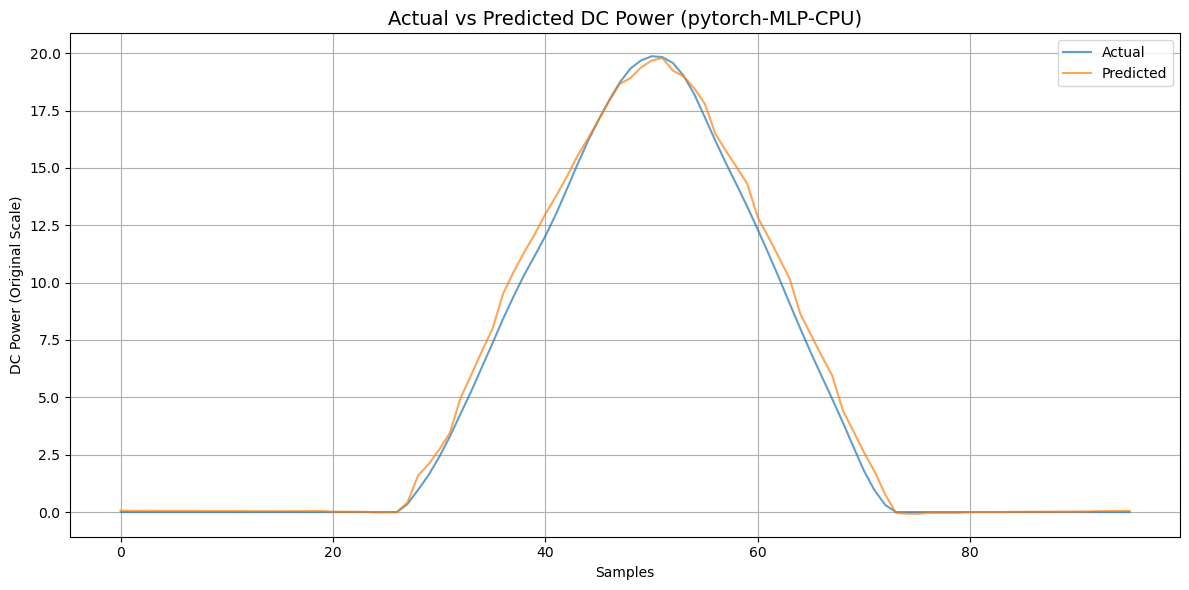

In [20]:
plt.figure(figsize=(12, 6))
plt.plot(val_targets, label='Actual', alpha=0.7)
plt.plot(val_preds, label='Predicted', alpha=0.7)
plt.title('Actual vs Predicted DC Power (pytorch-MLP-CPU)', fontsize=14)
plt.xlabel('Samples')
plt.ylabel('DC Power (Original Scale)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

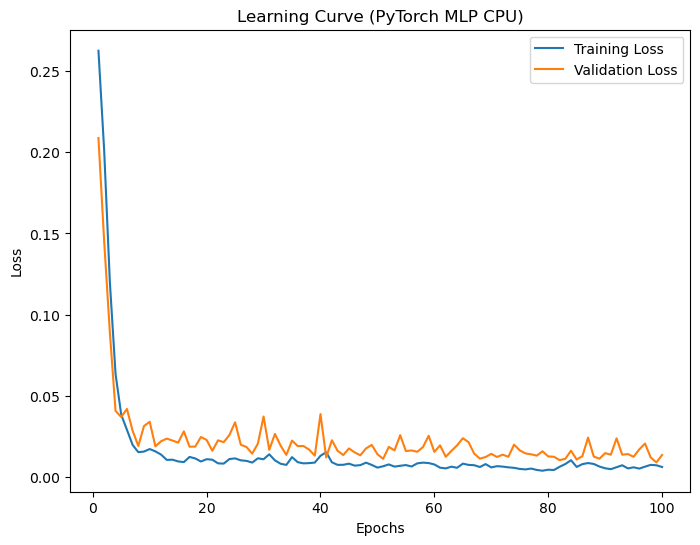

In [21]:
plt.figure(figsize=(8,6))
plt.plot(range(1, epochs+1), train_losses, label='Training Loss')
plt.plot(range(1, epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Learning Curve (PyTorch MLP CPU)')
plt.legend()
plt.show()


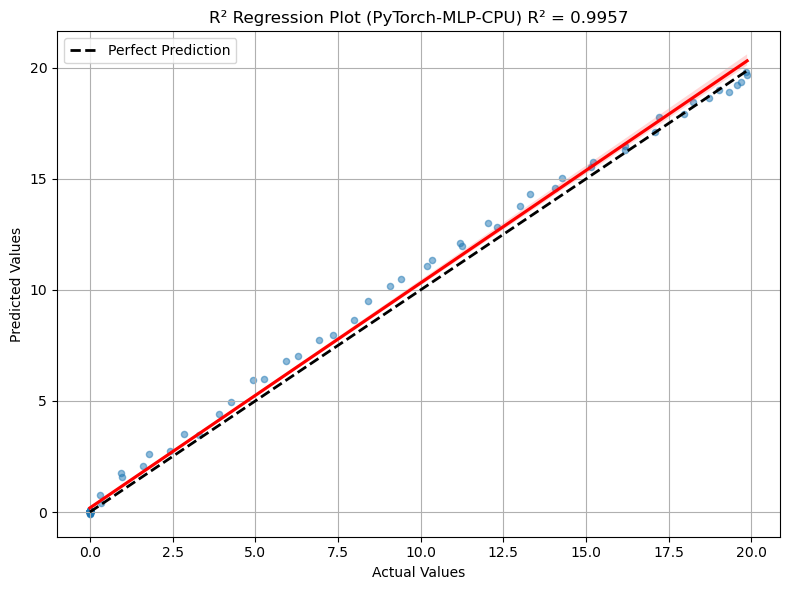

In [22]:
r2 = r2_score(val_targets, val_preds)

plt.figure(figsize=(8, 6))
sns.regplot(x=val_targets.flatten(), y=val_preds.flatten(), scatter_kws={"alpha":0.5, "s": 20}, line_kws={"color":"red"})
plt.plot([val_targets.min(), val_targets.max()], [val_targets.min(), val_targets.max()], 'k--', lw=2, label='Perfect Prediction')

plt.title(f'R² Regression Plot (PyTorch-MLP-CPU) R² = {r2:.4f}')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


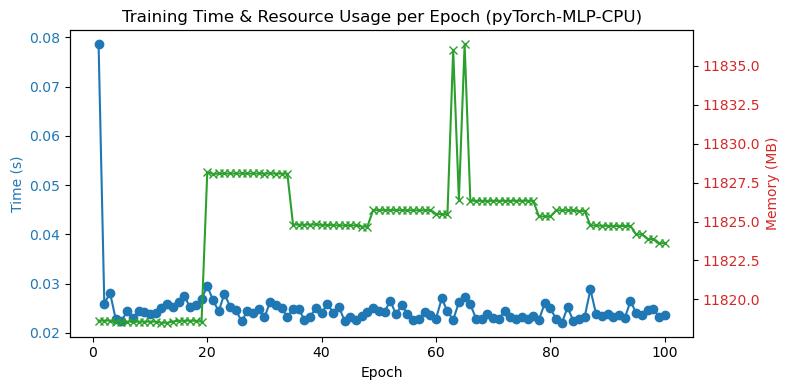

In [23]:
epochs_range = range(1, epochs+1)
fig, ax1 = plt.subplots(figsize=(8,4))
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Time (s)", color="tab:blue")
ax1.plot(epochs_range, epoch_times, color="tab:blue", marker="o", label="Time per epoch")
ax1.tick_params(axis='y', labelcolor="tab:blue")

ax2 = ax1.twinx()
ax2.set_ylabel("Memory (MB)", color="tab:red")

if device.type == 'cuda':
    ax2.plot(epochs_range, gpu_memory, color="tab:red", marker="x", label="GPU Memory")
else:
    ax2.plot(epochs_range, cpu_memory, color="tab:green", marker="x", label="CPU Memory")

ax2.tick_params(axis='y', labelcolor="tab:red")
plt.title("Training Time & Resource Usage per Epoch (pyTorch-MLP-CPU)")
fig.tight_layout()
plt.show()

## LSTM

In [24]:
import torch 
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import time,psutil,GPUtil
import matplotlib.pyplot as plt
import seaborn as sns

In [25]:
df_lstm = df.copy()

In [26]:
features = ['AMBIENT_TEMPERATURE', 'IRRADIATION', 'DC_PER_IRR',
       'HOUR_SIN', 'HOUR_COS', 'IS_NIGHT', 'DAWN_DUSK', 
       'IRR_15MIN_AGO', 'TEMP_30MIN_AGO', 'DAY_OF_WEEK', 'IS_WEEKEND']
target = ['DC_POWER']
scale = ['AMBIENT_TEMPERATURE', 'IRRADIATION', 'DC_PER_IRR','IRR_15MIN_AGO', 'TEMP_30MIN_AGO']

In [27]:
X_to_scale = df_lstm[scale]
X_rest = df_lstm[[col for col in features if col not in scale]]

scaler_x = MinMaxScaler()
X_scaled = pd.DataFrame(scaler_x.fit_transform(X_to_scale), columns=scale, index=df_lstm.index)

X = pd.concat([X_scaled, X_rest], axis=1)[features]

In [28]:
dump(scaler_x,'../model/lstm_x_scaler_cpu_pyt.joblib')

['../model/lstm_x_scaler_cpu_pyt.joblib']

In [29]:
y = df_lstm[target]

scaler_y = MinMaxScaler()
y_scaled = pd.DataFrame(scaler_y.fit_transform(y),columns=target,index=df_lstm.index)
y = y_scaled

In [30]:
dump(scaler_y,'../model/lstm_y_scaler_cpu_pyt.joblib')

['../model/lstm_y_scaler_cpu_pyt.joblib']

In [31]:
train_size = int(len(X) * 0.8)
X_train, X_val = X[:train_size], X[train_size:]
y_train, y_val = y[:train_size], y[train_size:]

In [32]:
y_train = y_train.to_numpy().reshape(-1, 1)
y_val = y_val.to_numpy().reshape(-1, 1)
X_train = X_train.to_numpy().reshape((X_train.shape[0], 1, X_train.shape[1]))
X_val = X_val.to_numpy().reshape((X_val.shape[0], 1, X_val.shape[1]))

In [33]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1,1)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).view(-1,1)

In [34]:
input_dim = X_train.shape[2]

lstm1 = nn.LSTM(input_size=input_dim, hidden_size=128, batch_first=True).to(device)
lstm2 = nn.LSTM(input_size=128, hidden_size=64, batch_first=True).to(device)
dense_layers = nn.Sequential(
    nn.Linear(64, 64),
    nn.LeakyReLU(0.1),
    nn.Linear(64, 32),
    nn.LeakyReLU(0.1),
    nn.Linear(32, 1)
).to(device)

criterion = nn.L1Loss()
optimizer = optim.Adam(
    list(lstm1.parameters()) + list(lstm2.parameters()) + list(dense_layers.parameters()), lr=0.001
)


In [35]:
batch_size = 32
train_dataset = data.TensorDataset(torch.tensor(X_train, dtype=torch.float32),
                                   torch.tensor(y_train, dtype=torch.float32))
train_loader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = data.TensorDataset(torch.tensor(X_val, dtype=torch.float32),
                                 torch.tensor(y_val, dtype=torch.float32))
val_loader = data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [36]:
# ====== Tracking ======
epochs = 100
train_losses, val_losses = [], []
epoch_times, gpu_memory, cpu_memory = [], [], []
val_r2, val_mae, val_rmse = [], [], []
# ====== Training ======
start = time.time()
for epoch in range(epochs):
    t0 = time.time()
    lstm1.train(); lstm2.train(); dense_layers.train()
    running_loss = 0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        out1, _ = lstm1(X_batch)
        out2, _ = lstm2(out1)
        out = dense_layers(out2[:, -1, :])  # Shape: [batch_size, 1]
        loss = criterion(out, y_batch)  # Removed .squeeze() to keep shape [batch_size, 1]
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_losses.append(running_loss / len(train_loader))

    # Validation
    lstm1.eval(); lstm2.eval(); dense_layers.eval()
    val_loss = 0
    val_preds = []
    val_targets = []
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            out1, _ = lstm1(X_batch)
            out2, _ = lstm2(out1)
            out = dense_layers(out2[:, -1, :])  # Shape: [batch_size, 1]
            val_loss += criterion(out, y_batch).item()
            val_preds.append(out.cpu().numpy())
            val_targets.append(y_batch.cpu().numpy())
    val_losses.append(val_loss / len(val_loader))
    val_preds = np.vstack(val_preds)  # Already in shape [n_samples, 1]
    val_targets = np.vstack(val_targets)  # Already in shape [n_samples, 1]


    # Metrics
    mae = mean_absolute_error(val_targets, val_preds)
    rmse = np.sqrt(mean_squared_error(val_targets, val_preds))
    r2 = r2_score(val_targets, val_preds)

    val_mae.append(mae)
    val_rmse.append(rmse)
    val_r2.append(r2)
    epoch_times.append(time.time() - t0)

    # Resource usage

    mem = psutil.virtual_memory().used / (1024 ** 2)  # MB
    cpu_memory.append(mem)
    gpu_memory.append(None)

    print(f"Epoch [{epoch+1}/{epochs}] - Train Loss: {train_losses[-1]:.4f}, "
          f"Val Loss: {val_losses[-1]:.4f}, Time: {epoch_times[-1]:.2f}s")

end = time.time()
print(f"Total training time: {end - start:.2f} seconds")

Epoch [1/100] - Train Loss: 0.2647, Val Loss: 0.2357, Time: 0.16s
Epoch [2/100] - Train Loss: 0.2471, Val Loss: 0.2070, Time: 0.06s
Epoch [3/100] - Train Loss: 0.2059, Val Loss: 0.1536, Time: 0.06s
Epoch [4/100] - Train Loss: 0.1294, Val Loss: 0.1200, Time: 0.05s
Epoch [5/100] - Train Loss: 0.0799, Val Loss: 0.0479, Time: 0.05s
Epoch [6/100] - Train Loss: 0.0444, Val Loss: 0.0296, Time: 0.06s
Epoch [7/100] - Train Loss: 0.0271, Val Loss: 0.0377, Time: 0.08s
Epoch [8/100] - Train Loss: 0.0200, Val Loss: 0.0178, Time: 0.06s
Epoch [9/100] - Train Loss: 0.0181, Val Loss: 0.0205, Time: 0.06s
Epoch [10/100] - Train Loss: 0.0160, Val Loss: 0.0226, Time: 0.07s
Epoch [11/100] - Train Loss: 0.0174, Val Loss: 0.0228, Time: 0.06s
Epoch [12/100] - Train Loss: 0.0160, Val Loss: 0.0197, Time: 0.06s
Epoch [13/100] - Train Loss: 0.0164, Val Loss: 0.0233, Time: 0.07s
Epoch [14/100] - Train Loss: 0.0185, Val Loss: 0.0331, Time: 0.08s
Epoch [15/100] - Train Loss: 0.0144, Val Loss: 0.0187, Time: 0.06s
Epoc

In [37]:
print(f'MAE :{mean_absolute_error(val_targets, val_preds):.4f}')
print(f'rmse = {np.sqrt(mean_squared_error(val_targets, val_preds)):.4f}')
print(f'r2 = {r2_score(val_targets, val_preds):.4f}')
print(f'Training Time = {end_total - start_total}')

MAE :0.0141
rmse = 0.0238
r2 = 0.9947
Training Time = 3.2812647819519043


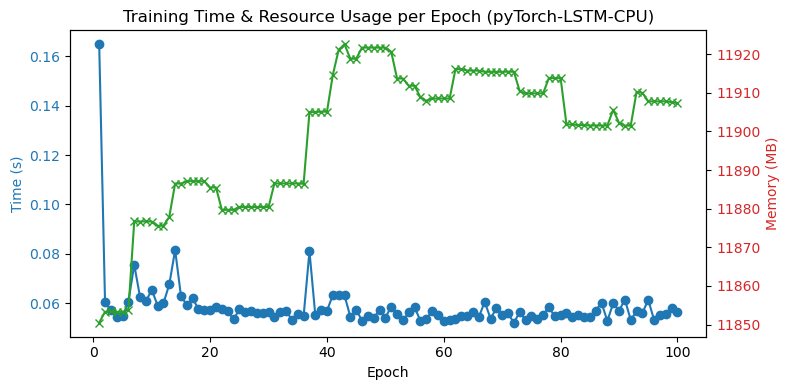

In [38]:
epochs_range = range(1, epochs+1)
fig, ax1 = plt.subplots(figsize=(8,4))
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Time (s)", color="tab:blue")
ax1.plot(epochs_range, epoch_times, color="tab:blue", marker="o", label="Time per epoch")
ax1.tick_params(axis='y', labelcolor="tab:blue")

ax2 = ax1.twinx()
ax2.set_ylabel("Memory (MB)", color="tab:red")

if device.type == 'cuda':
    ax2.plot(epochs_range, gpu_memory, color="tab:red", marker="x", label="GPU Memory")
else:
    ax2.plot(epochs_range, cpu_memory, color="tab:green", marker="x", label="CPU Memory")

ax2.tick_params(axis='y', labelcolor="tab:red")
plt.title("Training Time & Resource Usage per Epoch (pyTorch-LSTM-CPU)")
fig.tight_layout()
plt.show()

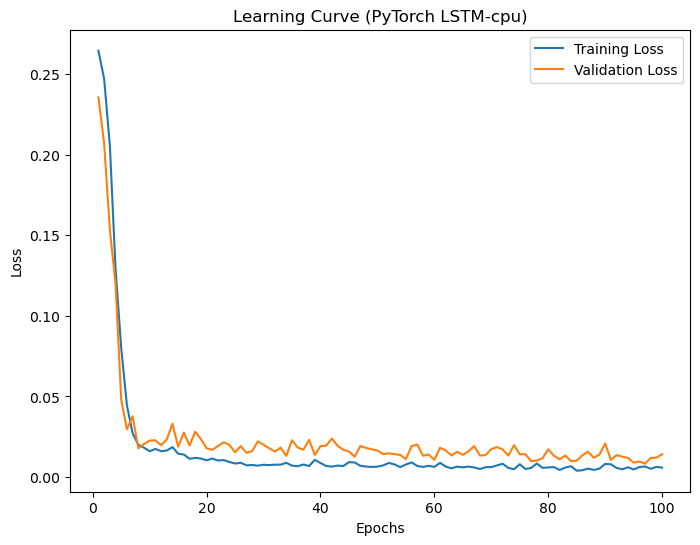

In [39]:
plt.figure(figsize=(8,6))
plt.plot(range(1, epochs+1), train_losses, label='Training Loss')
plt.plot(range(1, epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Learning Curve (PyTorch LSTM-cpu)')
plt.legend()
plt.show()


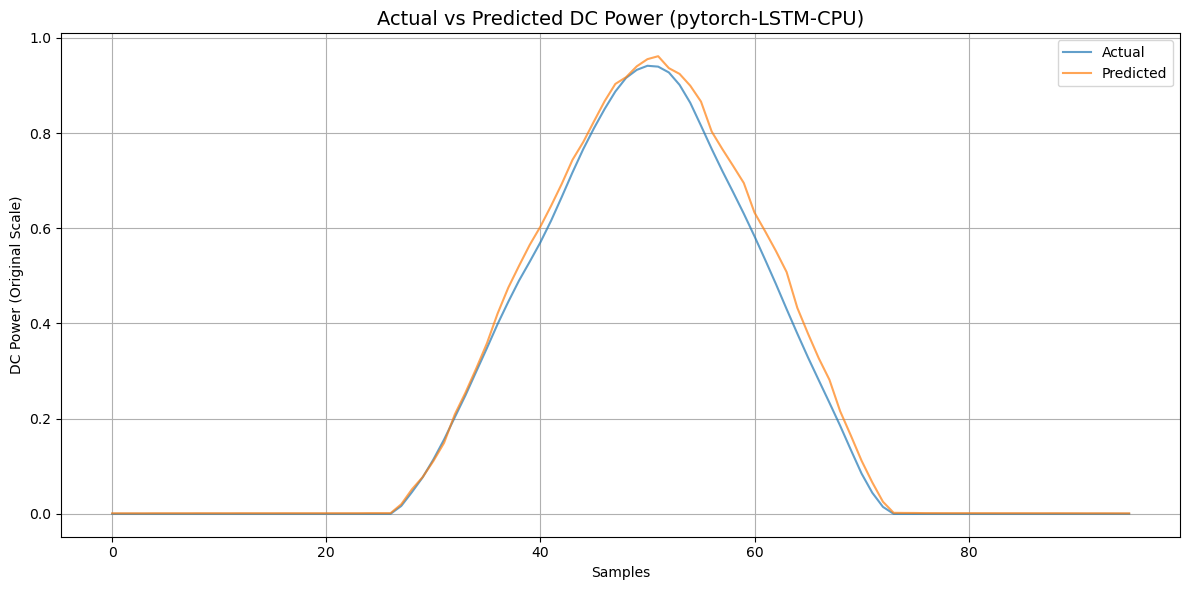

In [40]:
plt.figure(figsize=(12, 6))
plt.plot(val_targets, label='Actual', alpha=0.7)
plt.plot(val_preds, label='Predicted', alpha=0.7)
plt.title('Actual vs Predicted DC Power (pytorch-LSTM-CPU)', fontsize=14)
plt.xlabel('Samples')
plt.ylabel('DC Power (Original Scale)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

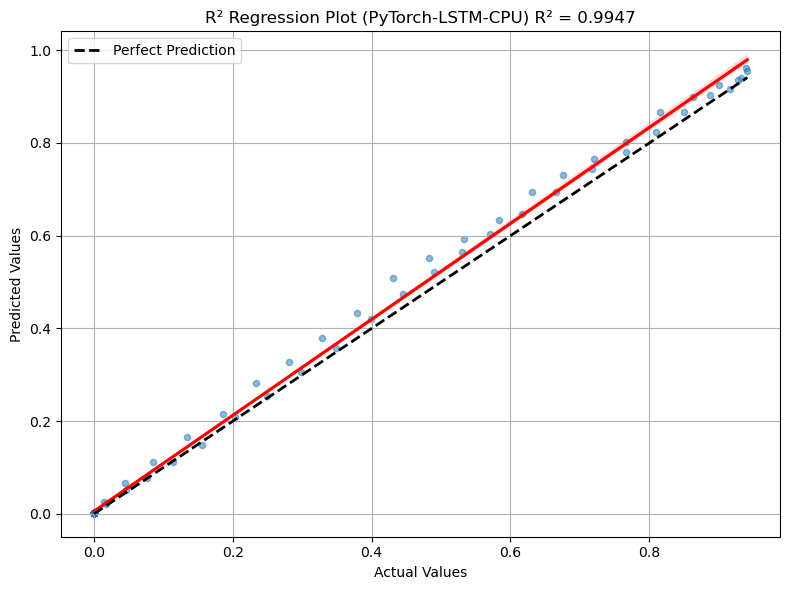

In [41]:
r2 = r2_score(val_targets, val_preds)

plt.figure(figsize=(8, 6))
sns.regplot(x=val_targets.flatten(), y=val_preds.flatten(), scatter_kws={"alpha":0.5, "s": 20}, line_kws={"color":"red"})
plt.plot([val_targets.min(), val_targets.max()], [val_targets.min(), val_targets.max()], 'k--', lw=2, label='Perfect Prediction')

plt.title(f'R² Regression Plot (PyTorch-LSTM-CPU) R² = {r2:.4f}')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
